In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import sys

project_root = Path("/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis")
sys.path.insert(0, str(project_root))
  
from perinuclear_analysis.core import BackgroundSubtractionConfig, PreprocessingConfig
from perinuclear_analysis.imaging_preprocessing.background_subtraction import BackgroundSubtractor
from perinuclear_analysis.data_processing import ImageLoader

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/perinuclear_analysis/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/perinuclear_analysis/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'perinuclear_analysis.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/perinuclear_analysis/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'perinuclear_analysis.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


In [3]:
image_path = Path("/Users/gabrielduarte/Documents/GitHub/SaezAtienzar/perinuclear_analysis/data/ALIX/nd2/anti_ALIX_15_min_1.ome.tiff")

image_loader = ImageLoader()
loaded_data = image_loader.load_image(image_path)

INFO:perinuclear_analysis.data_processing.image_loader:Loaded metadata from converted TIFF: pixel_size=0.108333333333333μm
INFO:perinuclear_analysis.data_processing.image_loader:Successfully loaded TIFF image with shape: (23, 1800, 1800, 4)


In [4]:
len(loaded_data.shape)

#channel_names = image_loader.get_channel_names()

image_loader.rename_channels(["LAMP1", "Phalloidin", "ALIX", "DAPI"])
channel_names = image_loader.get_channel_names()




INFO:perinuclear_analysis.data_processing.image_loader:Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [6]:
channel_names = image_loader.get_channel_names()

channel_names

['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']

In [9]:
bg_subtractor = BackgroundSubtractor()

pixel_size = image_loader.get_pixel_size()
pixel_size

results = {}

for channel_name in channel_names:
    recommendations = bg_subtractor.get_recommended_parameters(channel_name)
    print(f"Recommendations for {channel_name}:")
    print(f"  Method: {recommendations['method']}")
    print(f"  Radius: {recommendations['radius']}")
    print(f"  Description: {recommendations['description']}")
    print()

Recommendations for LAMP1:
  Method: rolling_ball
  Radius: 30
  Description: LAMP1 punctate structures - medium radius for vesicle preservation

Recommendations for Phalloidin:
  Method: rolling_ball
  Radius: 20
  Description: Phalloidin/actin - smaller radius to preserve filament structures

Recommendations for ALIX:
  Method: rolling_ball
  Radius: 30
  Description: Protein marker - standard radius for punctate/diffuse patterns

Recommendations for DAPI:
  Method: rolling_ball
  Radius: 50
  Description: DAPI/nuclear staining - rolling ball with large radius for nuclear regions



In [10]:
# Prepare images dictionary for batch processing
images_dict = {}
for i, channel_name in enumerate(channel_names):
    images_dict[channel_name] = loaded_data[:, :, :, i]

# Process all channels at once
batch_results = bg_subtractor.batch_process(
    images=images_dict,
    pixel_size=pixel_size
)

# Access results
for channel_name, (corrected_img, metadata) in batch_results.items():
    print(f"{channel_name}: {corrected_img.shape}, method={metadata['method']}")


INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Processing channel: LAMP1
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (23, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 23 slices (18.5 MB per slice)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Processing channel: Phalloidin
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (23, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 23 slices (18.5 MB per slice)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Processing channel: ALIX
INFO:perinucl

LAMP1: (23, 1800, 1800), method=rolling_ball
Phalloidin: (23, 1800, 1800), method=rolling_ball
ALIX: (23, 1800, 1800), method=rolling_ball
DAPI: (23, 1800, 1800), method=rolling_ball


In [5]:
import gc

bg_subtractor = BackgroundSubtractor()
pixel_size = image_loader.get_pixel_size()

# Process each channel with specific parameters - using middle slice only
results = {}
middle_slice_idx = loaded_data.shape[0] // 2  # Get middle slice index

print(f"Using middle slice {middle_slice_idx} out of {loaded_data.shape[0]} slices")

for i, channel_name in enumerate(channel_names):
    print(f"\nProcessing {channel_name}...")
    
    # Extract only the middle slice instead of all slices
    channel_data = loaded_data[middle_slice_idx, :, :, i]
    channel_data = np.expand_dims(channel_data, axis=0)  # Add Z dimension: (1, 1800, 1800)
    
    # Define specific parameters for each channel
    if channel_name == "DAPI":
        # Parameters for DAPI channel
        params = {
            'method': 'rolling_ball',
            'radius': 150,
            'light_background': False
        }
    elif channel_name == "Phalloidin":
        # Parameters for Phalloidin channel
        params = {
            'radius': 75,
            'light_background': True
        }
    else:
        # Default parameters for other channels
        params = {
            'method': 'rolling_ball',
            'radius': 100
        }
    
    # Process with specific parameters
    corrected_img, metadata = bg_subtractor.subtract_background(
        image=channel_data,
        channel_name=channel_name,
        pixel_size=pixel_size,
        **params
    )
    
    results[channel_name] = (corrected_img, metadata)
    print(f"{channel_name}: {corrected_img.shape}, method={metadata['method']}")
    
    # Force garbage collection after each channel
    del channel_data  # Explicitly delete the input data
    gc.collect()      # Force garbage collection
    print(f"Memory cleaned after {channel_name}")

print("\nAll channels processed successfully!")

INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (1, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 1 slices (18.5 MB per slice)


Using middle slice 11 out of 23 slices

Processing LAMP1...


INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (1, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 1 slices (18.5 MB per slice)


LAMP1: (1, 1800, 1800), method=rolling_ball
Memory cleaned after LAMP1

Processing Phalloidin...


INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (1, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 1 slices (18.5 MB per slice)


Phalloidin: (1, 1800, 1800), method=rolling_ball
Memory cleaned after Phalloidin

Processing ALIX...


INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Applying rolling_ball background subtraction to 3D image (1, 1800, 1800)
INFO:perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor:Calculated chunk size: 1 slices (18.5 MB per slice)


: 

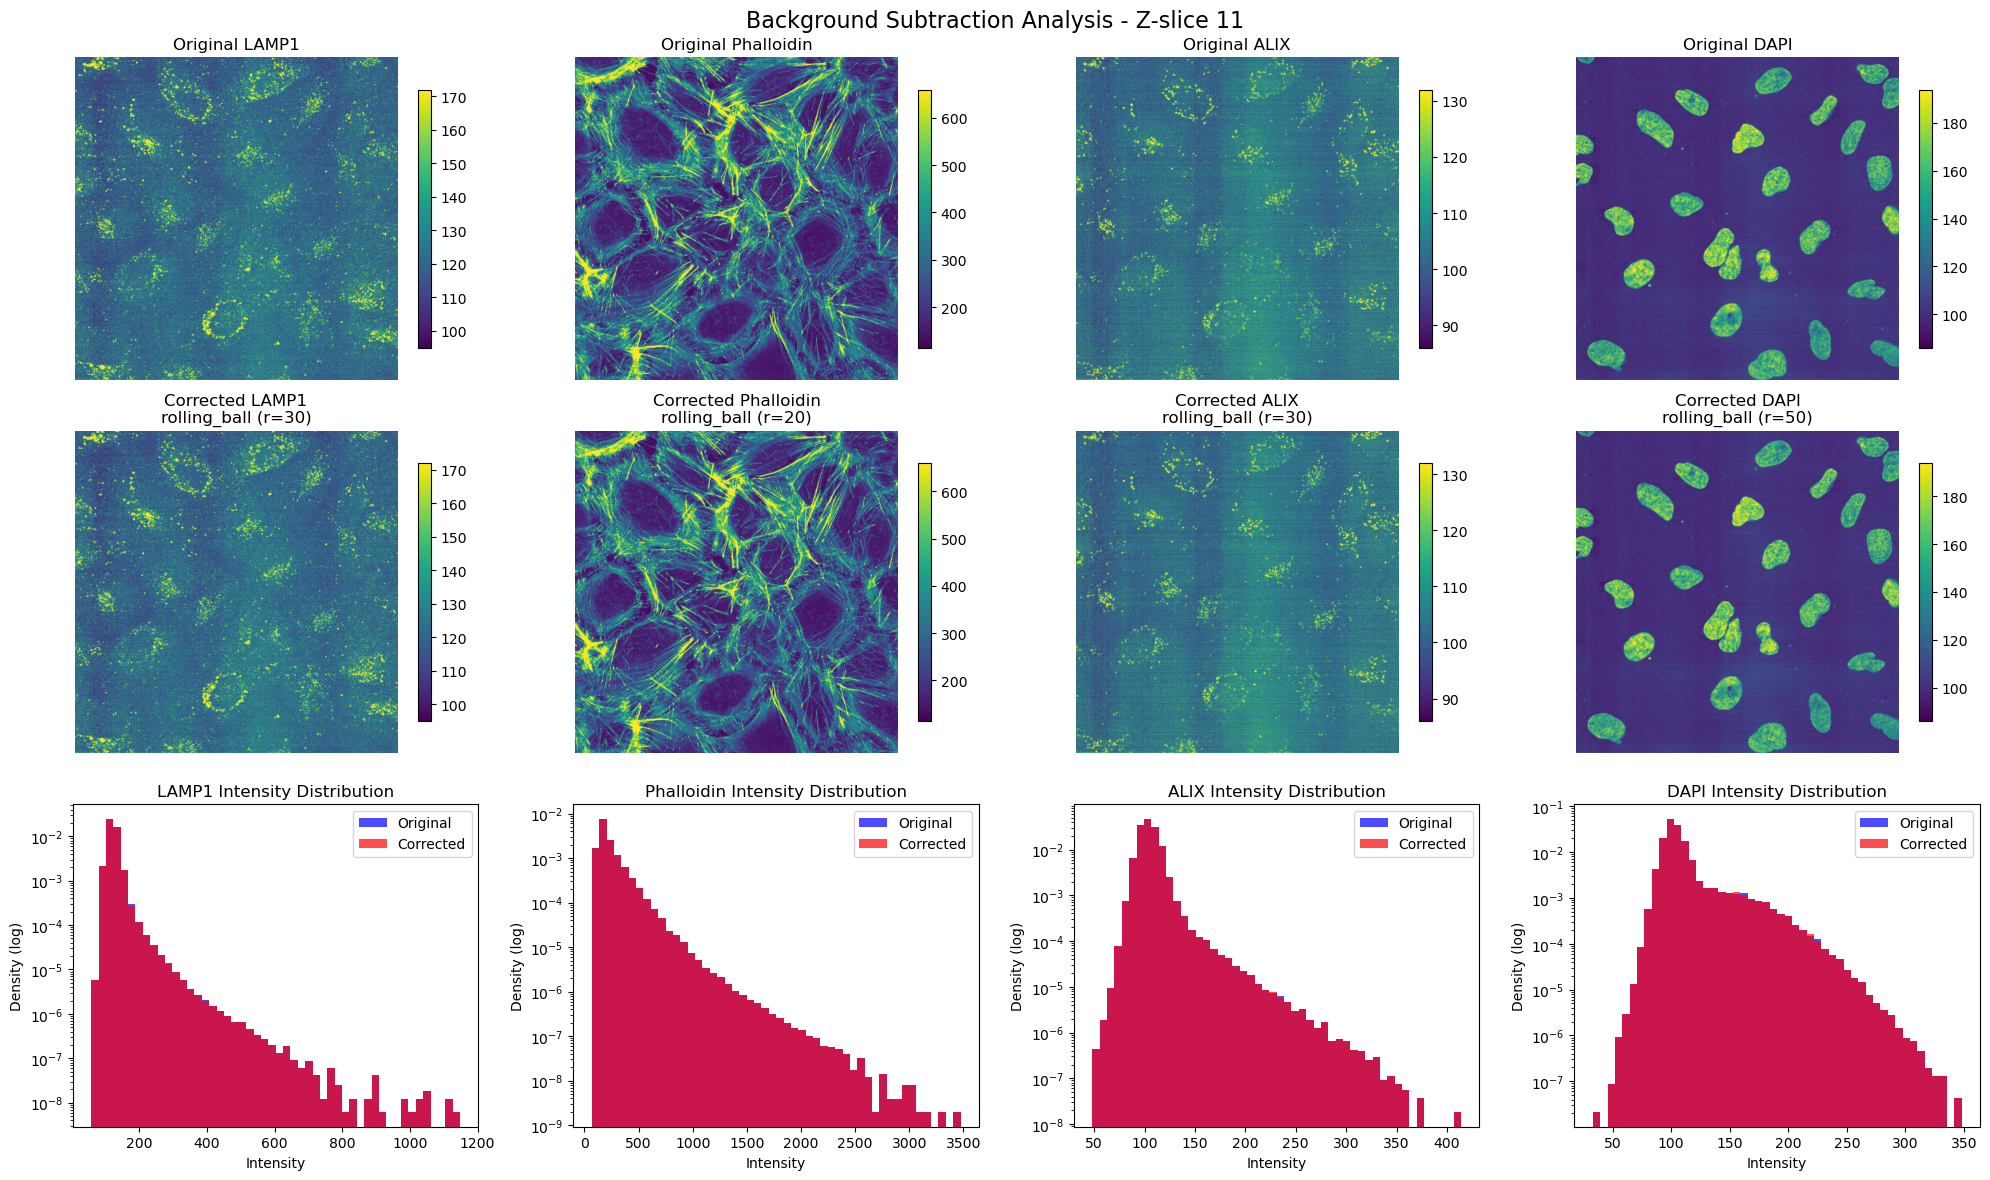

In [ ]:
# Plotting the middle slice of the image.
# To try different paramters; we will do it directly using .shape[]//2

def plot_detailed_channel_analysis(loaded_data, batch_results, channel_names, z_slice=None):
    """
    Detailed analysis plot with images, histograms, and statistics.
    """
    if z_slice is None:
        z_slice = loaded_data.shape[0] // 2
    
    n_channels = len(channel_names)
    fig, axes = plt.subplots(3, n_channels, figsize=(5 * n_channels, 12))
    
    if n_channels == 1:
        axes = axes.reshape(-1, 1)
    
    for i, channel_name in enumerate(channel_names):
        # Get data
        original_channel = loaded_data[:, :, :, i]
        corrected_img, metadata = batch_results[channel_name]
        
        # Calculate display ranges
        orig_p1, orig_p99 = np.percentile(original_channel, [1, 99])
        corr_p1, corr_p99 = np.percentile(corrected_img, [1, 99])
        
        # Row 1: Original images
        im_orig = axes[0, i].imshow(original_channel[z_slice], 
                                   cmap='viridis', 
                                   vmin=orig_p1, vmax=orig_p99)
        axes[0, i].set_title(f'Original {channel_name}')
        axes[0, i].axis('off')
        plt.colorbar(im_orig, ax=axes[0, i], shrink=0.8)
        
        # Row 2: Corrected images
        im_corr = axes[1, i].imshow(corrected_img[z_slice], 
                                   cmap='viridis', 
                                   vmin=corr_p1, vmax=corr_p99)
        method = metadata['method']
        radius = metadata['parameters_used'].get('radius', 'N/A')
        axes[1, i].set_title(f'Corrected {channel_name}\n{method} (r={radius})')
        axes[1, i].axis('off')
        plt.colorbar(im_corr, ax=axes[1, i], shrink=0.8)
        
        # Row 3: Histograms
        # Sample data for histogram (every 10th pixel to speed up)
        orig_sample = original_channel.flatten()[::10]
        corr_sample = corrected_img.flatten()[::10]
        
        axes[2, i].hist(orig_sample, bins=50, alpha=0.7, label='Original', 
                       density=True, color='blue')
        axes[2, i].hist(corr_sample, bins=50, alpha=0.7, label='Corrected', 
                       density=True, color='red')
        axes[2, i].set_title(f'{channel_name} Intensity Distribution')
        axes[2, i].set_yscale('log')
        axes[2, i].legend()
        axes[2, i].set_xlabel('Intensity')
        axes[2, i].set_ylabel('Density (log)')
    
    plt.suptitle(f'Background Subtraction Analysis - Z-slice {z_slice}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create the detailed analysis plot
plot_detailed_channel_analysis(loaded_data, batch_results, channel_names)

In [13]:
import numpy as np

z_slice = loaded_data.shape[0] // 2

for i, channel_name in enumerate(channel_names):
    original = loaded_data[z_slice, :, :, i]
    corrected, _ = batch_results[channel_name]
    
    #stats
    orig_mean = np.mean(original)
    orig_std = np.std(original)
    orig_min = np.min(original)
    orig_max = np.max(original)
    
    corr_mean = np.mean(corrected)
    corr_std = np.std(corrected)
    corr_min = np.min(corrected)
    corr_max = np.max(corrected)
    
    print(f"Channel: {channel_name}")
    print(f"Original: {orig_mean:.2f} ± {orig_std:.2f}, min={orig_min:.2f}, max={orig_max:.2f}")
    print(f"Corrected: {corr_mean:.2f} ± {corr_std:.2f}, min={corr_min:.2f}, max={corr_max:.2f}")
    print()
    
    negative_pixels = np.sum(corrected < 0)
    print(f"Negative pixels ({negative_pixels}): {negative_pixels / corrected.size:.2%}")
    
    
    


Channel: LAMP1
Original: 124.79 ± 18.08, min=56.00, max=742.00
Corrected: 122.16 ± 16.75, min=43.00, max=1148.00

Negative pixels (0): 0.00%
Channel: Phalloidin
Original: 291.16 ± 151.62, min=75.00, max=3012.00
Corrected: 215.40 ± 113.49, min=60.00, max=3608.99

Negative pixels (0): 0.00%
Channel: ALIX
Original: 104.84 ± 9.60, min=46.00, max=306.00
Corrected: 104.02 ± 9.71, min=38.00, max=463.00

Negative pixels (0): 0.00%
Channel: DAPI
Original: 109.94 ± 22.43, min=39.00, max=316.00
Corrected: 107.18 ± 19.56, min=33.00, max=371.00

Negative pixels (0): 0.00%
